# Visualising the pulsar data

This notebook visualises the frequency, $v$, vs phase data, $\phi$, recorded from the 42 ft telescope at JBO. The dispersion in the data is used to calculate the dispersion mesaure $DM$.
Finally, an optimization program is run to obtain the de-dispersed data.


In [10]:
# Importing libraries
from __future__ import (print_function, absolute_import, division)

# Auxixiliary libraries
import os

# Optimize library allows us to fit things
import scipy.optimize as opt

# The numpy library allows to do FFTs
import numpy as np
import scipy

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime

# The pyplot module from matplotlib allows to plot things.
from  matplotlib import pyplot as plt
import matplotlib

# pi is a useful value!
from math import pi

# This will tell matplotlib that we want to include the plots on our notebook, rather than in a new window.
%matplotlib inline

# Here you can control the font for the plots.
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## 2. Reading of Data Files

The raw data files to text (also called "ascii") files to make them easy to read in our python program. numpy provides a very helpful routine called `loadtxt` which will import columns from a text file. More description in present in the manual [here](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html).


In [3]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP")

# Get the data file path
data_file = os.path.join(data_dir, "B03529_Wed1.asc")

# Load the data using numpy loadtxt
chan_count,phase_count,data = np.loadtxt(data_file, usecols=(1,2,3), unpack=True, skiprows=1)

## 3. Plotting the Data

Nchan = 40 Nphase= 1024


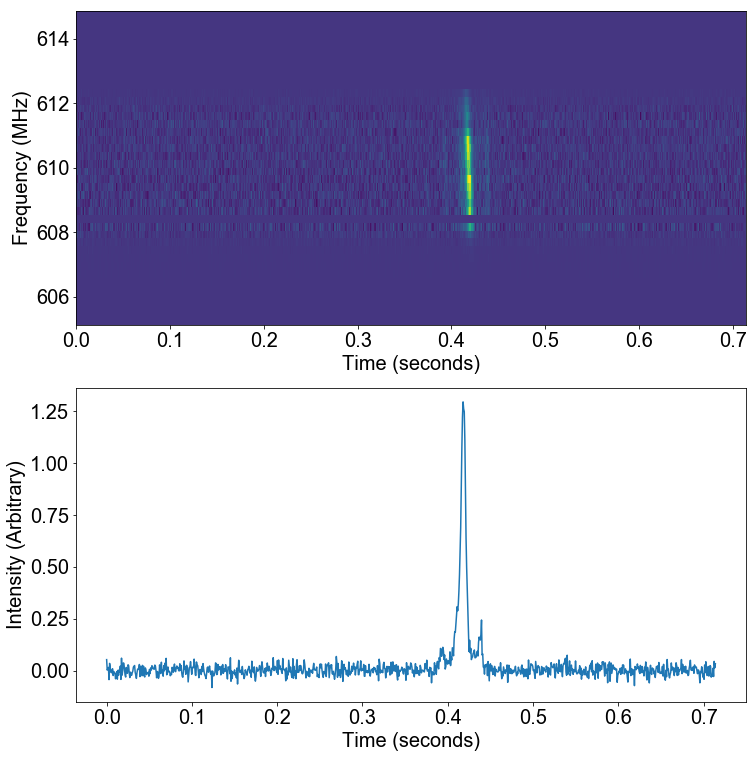

In [43]:
# Here we infer the number of channels and numnber of phase bins based on the last entry in the file.
nchan=int(chan_count[-1])+1
nphase=int(phase_count[-1])+1

# Print this out for verification
print("Nchan = {} Nphase= {}".format(nchan,nphase))

# Here is where we reshape the 1-d array into a 2-d data structure
raw=data.reshape(nchan,nphase)
iphase=phase_count.reshape(nchan,nphase)[0] 
ichan=chan_count.reshape(nchan,nphase)[:,0]

# We can integrate over all frequency channels by using the `sum` routine from numpy...
integrated=np.sum(raw,axis=0)

# Conversions of axis into physical units
freq = 605.125 + ichan * (10/nchan)
time = iphase*(0.71452/nphase)

# Plot the 2-d data:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.imshow(raw,aspect='auto',origin='lower',extent=(time[0],time[-1],freq[0],freq[-1]))
plt.xlabel("Time (seconds)",)
plt.ylabel("Frequency (MHz)")

# Plot the integrated profile:
plt.subplot(212)
plt.plot(time,integrated)
plt.xlabel("Time (seconds)")
plt.ylabel("Intensity (Arbitrary)")
#plt.title("Integrated profile")

plt.subplots_adjust(bottom=0.1, top=0.9)             
plt.show()

## 4. Dispersion

The pulsar signal experiences a frequency dependent delay caused by the interstellar plasma. This should be visiable in the frequency vs phase plot as a drift in the pulse as a function of frequency. This is called dispersion.

In order to measure and correct for the dispersion, you will need to convert the axes of your data to physical units.

The frequency axis can be determined from the central frequency and bandwidth of your instrument
The time axis can be determined from the period of the pulsar and the number of phase bins.


### De-dispersion
Correcting for the dispersion requires shifting the rows of your 2-d array by a frequency dependent time delay equal to the negative of the dispersion induced delay. This process is called "de-dispersion". Once de-dispersed, integrating over frequency channels should give improved signal-to-noise and a narrower pulse.

To get you started, we have provided a function `shift_rows` which will rotate each row of a 2-d matrix by the number of bins specified in the `shifts` array.

The demo program will use this to shift each row by an arbitrary amount, you will need to modify the program to shift by the time delay caused by a given "dispersion measure" (DM). Read the lab script for more information about how to compute this time delay.

Modify this program to correct the data for a given DM. Try a few values of DM (see if you can find common values for dispersion measure of pulsars) and see if you can roughly detrmine the value that maximises the DM. Check with your demonstrator if your DM value is sensible. You should extend your program to try to determine the DM in a more rigourous way. There are many ways to do this, if you are stuck, discuss with your demonstrator.

### 4.1 Shifting Functions

In [44]:
def shift_rows(data_in, shifts):
    """
    Shifts the rows of the data by amount in variable "shifts".
    
    @param data_in :: data to be shifted
    @param shifts :: amount to be shifted by
    
    @returns :: sifted data
    """
    
    shifted=np.zeros_like(data_in)
    for chan in range(nchan):
        shifted[chan] += np.roll(data_in[chan],int(shifts[chan]))
    return shifted

def shifting(x, freq):
    """
    Shifts the data by an array times the variable m.
    Tries to dedisperse the data this way.
    
    @param m :: shifting parameter
    @param nchan :: number of channels in the data
    @param ichan :: array to be shifted with
    
    @returns :: negative of the maximum of the integrated frequency
    """
    
    bindelay = (x[0]*4148.8*nphase)/(0.71452*pow(freq, 2))
    dedispersed = shift_rows(raw,bindelay)
    integrated =np.sum(dedispersed,axis=0)
    
    return -np.amax(integrated)


def shifting_results(x, freq):
    """
    Does the same thing as function shifting.
    
    @returns :: the bindelay, dedispersed and integrated
                numpy arrays
    """
    
    bindelay = (x[0]*4148.8*nphase)/(0.71452*pow(freq, 2))  
    dedispersed = shift_rows(raw, bindelay)
    integrated=np.sum(dedispersed,axis=0)
    
    return bindelay, dedispersed, integrated

### 4.2 Optimisation

[-0.04174743 -0.02020196 -0.0355188  ...  0.01118363  0.05781597
 -0.02273617]
Dispersion Measure: 30.00000
Corresponding maximum value of intensity 1.07009


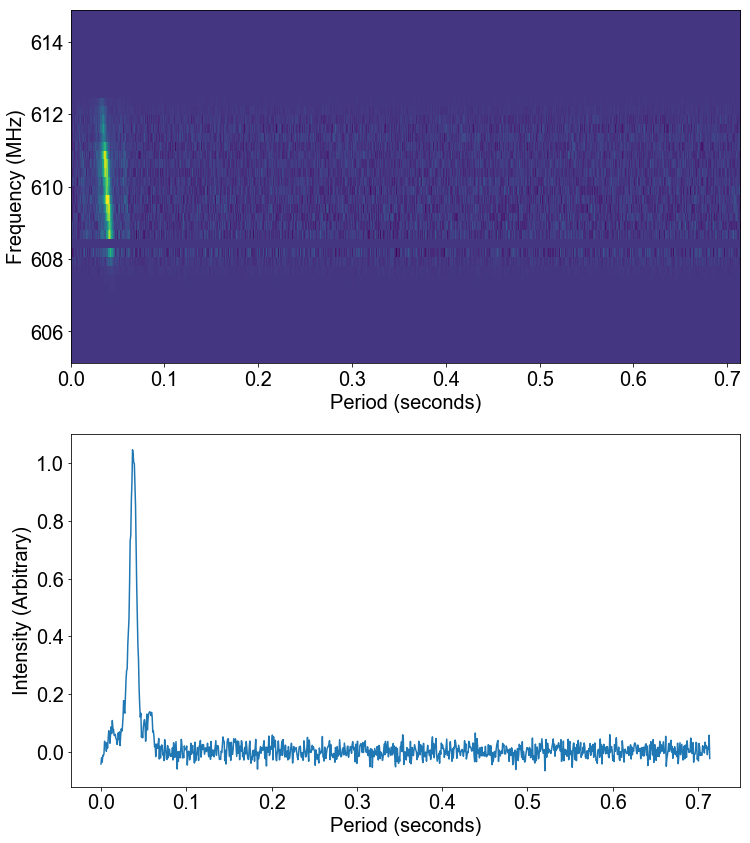

In [98]:
res = opt.minimize(shifting, [30], freq, method="Nelder-Mead")
bindelay, dedispersed, integrated = shifting_results(res.x, freq)
print(integrated)
print("Dispersion Measure: %2.5f" %(abs(res.x[0])))
print("Corresponding maximum value of intensity %2.5f" %(-res.fun))

# plot the data again... If you have de-dispersed correctly, the S/N should be maximised.
plt.figure(figsize=(12,12))
plt.subplot(211)

# Plots
plt.imshow(dedispersed,aspect='auto',origin='lower',extent=(time[0],time[-1],freq[0],freq[-1]))
plt.xlabel("Period (seconds)")
plt.ylabel("Frequency (MHz)")

plt.subplot(212)
plt.plot(time,integrated)
plt.xlabel("Period (seconds)")
plt.ylabel("Intensity (Arbitrary)")
#plt.title("Integrated profile")
axes = plt.gca()

plt.subplots_adjust(bottom=0.001, top=0.9)             
plt.show()

### 5. Estimation of Errors

#### 5.1 Statistical Uncertainty
The statistical uncertainty in the $DM$ arises due to the random fluctuating component in the detected signal. This uncertainty has been accounted for below. 

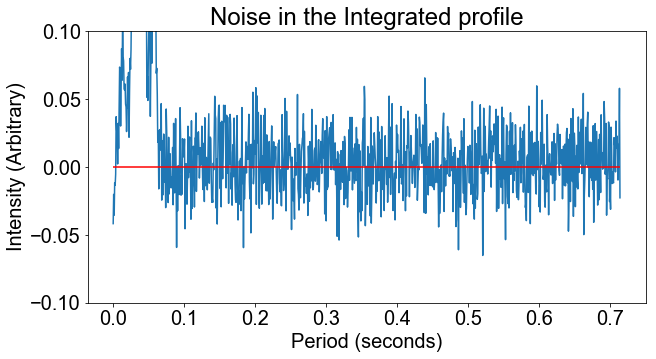

Statistical Uncertainty due to Noise = 0.0217122454319


In [99]:
# Plots the noise in the date
plt.figure(figsize=(10,5))
plt.plot(time,integrated, zorder=1)
plt.hlines(y=0,xmin=0, xmax=0.71452, colors='r', linestyles='solid', zorder=2)
plt.xlabel("Period (seconds)")
plt.ylabel("Intensity (Arbitrary)")
plt.title("Noise in the Integrated profile")
axes = plt.gca()
# If noise is larger, limits need to be changes to estimate upperbound
axes.set_ylim([-0.1,0.1])
plt.show()

# calculates the noise in the integrated array + estimates the uncertainty
Noise = integrated[np.where(integrated < 0.05)]
ErrNoise = np.std(Noise)
print("Statistical Uncertainty due to Noise = {}".format(ErrNoise))

#### 5.2 Systematic Uncertainty

The systematic uncertainty due to the optimization algorithm [...]